# ML Project: Flight delay

Main notebook

Import modules

In [199]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from geopy.distance import geodesic

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso

from prepare_flight_data import *
from feature_engineering import *

RSEED = 42

Load data and prepare data

In [200]:
df, df_test = load_prepare_flight_data()
df.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,icao_ARR,iata_ARR,name_ARR,city_ARR,subd_ARR,country_ARR,elevation_ARR,lat_ARR,lon_ARR,tz_ARR
0,train_id_15674,2016-01-01,TU 0564,NKC,TUN,2016-01-01 00:15:00,2016-01-01 04:30:00,ATA,TU 320IMV,0.0,...,DTTA,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22,36.851002,10.22720,Africa/Tunis
1,train_id_15676,2016-01-01,TU 0714,JED,TUN,2016-01-01 00:55:00,2016-01-01 05:30:00,ATA,TU 332IFM,195.0,...,DTTA,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22,36.851002,10.22720,Africa/Tunis
2,train_id_15675,2016-01-01,TU 0614,DKR,TUN,2016-01-01 01:20:00,2016-01-01 05:55:00,ATA,TU 320IMU,49.0,...,DTTA,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22,36.851002,10.22720,Africa/Tunis
3,train_id_30980,2016-01-01,UG 0002,TUN,DJE,2016-01-01 06:15:00,2016-01-01 07:15:00,SCH,UG AT7LBD,0.0,...,DTTJ,DJE,Djerba Zarzis International Airport,Djerba,Madanin,TN,19,33.875000,10.77550,Africa/Tunis
4,train_id_7179,2016-01-01,TU 0880,TUN,AMS,2016-01-01 06:30:00,2016-01-01 09:20:00,ATA,TU 736IOP,36.0,...,EHAM,AMS,Amsterdam Airport Schiphol,Amsterdam,North Holland,NL,-11,52.308601,4.76389,Europe/Amsterdam


Feature engineering
Runs around 15 seconds!

In [201]:
# Calculate distances
df = lat_lon_distance(df)
df_test = lat_lon_distance(df_test)
# Initialize custom transformer
features_enable = [1, 1, 1, 1, 1] # [domestic, dep_hour, dep_weekday, duration_min, operator]
# Pipeline to add features
attr_addr = flight_preprocessor(features_enable)
df = attr_addr.fit_transform(df)
df_test = attr_addr.transform(df_test)
# Store ID for submission
sub_id = df_test.ID
# Drop unimportant columns
cols_to_drop = ["icao_DEP", "iata_DEP", "name_DEP", "subd_DEP", "city_DEP", 
                "icao_ARR", "iata_ARR", "name_ARR", "subd_ARR", "city_ARR", 
                "ID", 'DATOP', "STA", "STD", 'tz_DEP', 'tz_ARR']
df = drop_column(df, cols_to_drop)
df_test = drop_column(df_test, cols_to_drop)

/Users/cmw/python_work/flight-delay/feature_engineering.py:58: FutureWarning: The default value of regex will change from True to False in a future version.
  df["operator"] = df.FLTID.str.replace('\d+', '')


In [202]:
df.columns

Index(['FLTID', 'DEPSTN', 'ARRSTN', 'STATUS', 'AC', 'target', 'country_DEP',
       'elevation_DEP', 'lat_DEP', 'lon_DEP', 'country_ARR', 'elevation_ARR',
       'lat_ARR', 'lon_ARR', 'distance', 'domestic', 'dep_hour', 'dep_weekday',
       'duration_min', 'operator', 'arr_hour', 'dep_dayofyear', 'year'],
      dtype='object')

Train-test-split

In [203]:
# Train dataset
X = df.copy()
y = X.pop("target")
# Test dataset for submission
X_submission = df_test
# Outliers removed to improve model?
df_clean = remove_outliers(df.copy(), "target", sigma=5)
X_clean = df_clean.copy()
y_clean = X_clean.pop("target")
# Test-train-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)
print("Train size: ", y_train.shape, "\n" "Test size: ", y_test.shape)
# Data without outliers
#X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, 
#                                                                            test_size=0.99, 
#                                                                            random_state=RSEED,
#                                                                            )

Train size:  (75483,) 
Test size:  (32350,)


In [204]:
# Create poly features
#X = df.copy()
#y = X.pop("target")
#poly = PolynomialFeatures(2)
#X_train_poly = poly.fit_transform(X_train)
#X_test_poly = poly.transform(X_test)

In [205]:
# shape of data before removing outliers
X_train.shape, X_test.shape

((75483, 22), (32350, 22))

In [206]:
sigma=5
X_train = X_train[y_train < (y_train.median() + sigma * y_train.std())]
y_train = y_train[y_train < (y_train.median() + sigma * y_train.std())]

In [207]:
# shape of data after removing outliers
X_train.shape, X_test.shape

((74983, 22), (32350, 22))

Preprocessing pipeline

Encoding of categorical features

In [208]:
categories_country_ARR = [np.asarray(df.groupby("country_ARR").mean().sort_values(by="target").index)]
categories_country_DEP = [np.asarray(df.groupby("country_DEP").mean().sort_values(by="target").index)]
categories_DEPSTN = [np.asarray(df.groupby("DEPSTN").mean().sort_values(by="target").index)]
categories_ARRSTN = [np.asarray(df.groupby("ARRSTN").mean().sort_values(by="target").index)]
categories_FLTID = [np.asarray(df.groupby("FLTID").mean().sort_values(by="target").index)]
categories_AC = [np.asarray(df.groupby("AC").mean().sort_values(by="target").index)]

In [209]:
# Preprocessor pipelines
num_cols = ['elevation_DEP', 'elevation_ARR', 'distance', 'domestic', 'dep_hour', 'dep_weekday',
            'duration_min', "lat_DEP", "lat_ARR", "lon_DEP", "lon_ARR"]
cat_cols = ["STATUS", "operator"]
# Preprocessor for numerical features
num_pipeline = Pipeline([
    ('num_scaler', StandardScaler()
])

num_pipeline = Pipeline([
    ('num_scaler', StandardScaler()),
    ('num_poly_transformer', PolynomialFeatures(2))
])

# Preprocessor for categorical features 
cat_pipeline = Pipeline([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))
])
# Put together preprocessor pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
    ('cat_AC', OrdinalEncoder(categories=categories_AC, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_AC[0])+1)), ["AC"]),
    ('cat_FLTID', OrdinalEncoder(categories=categories_FLTID, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_FLTID[0])+1)), ["FLTID"]),
    ('cat_ARRSTN', OrdinalEncoder(categories=categories_ARRSTN, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_ARRSTN[0])+1)), ["ARRSTN"]),
    ('cat_DEPSTN', OrdinalEncoder(categories=categories_DEPSTN, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_DEPSTN[0])+1)), ["DEPSTN"]),
    ('cat_country_ARR', OrdinalEncoder(categories=categories_country_ARR, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_country_ARR[0])+1)), ["country_ARR"]),
    ('cat_country_DEP', OrdinalEncoder(categories=categories_country_DEP, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_country_DEP[0])+1)), ["country_DEP"])
])

Model pipeline

In [210]:
pipe_en = Pipeline([
    # ('attr_addr', features_pipeline),
    ('preprocessor', preprocessor),
    ('en', ElasticNet())
])

In [211]:
param_grid = { 
    'en__alpha': np.linspace(1, 1, 1), # global weight of penalty; default to 1
    'en__l1_ratio': np.linspace(1, 1, 1),  # 0 => l1, 1 => l2; default to 0.5
    #'en__normalize' : [False], # normalizing the features; default to False
    'en__max_iter' :[10000], # default to 1000
    'en__tol': [1e-4], # tolerance of the optimization
             }

#param_grid = {}

In [212]:
# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(pipe_en,  param_grid, scoring='neg_root_mean_squared_error',
                  cv=5, verbose=0, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
gs.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_scaler',
                                                                                          StandardScaler())]),
                                                                         ['elevation_DEP',
                                                                          'elevation_ARR',
                                                                          'distance',
                                                                          'domestic',
                                                                          'dep_hour',
                                                                          'dep_weekday',
                                                                          'duration_min',
           

In [213]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

# Get the best estimator
best_model = gs.best_estimator_["en"]
type(best_model)

# Making predictions on the train dataset
y_pred = gs.predict(X_train)
#y_pred = best_model.predict(X_train)
score = mean_squared_error(y_train, y_pred, squared=False)
print("RMSE for train dataset", score)

# Making predictions on the test dataset
y_pred = gs.predict(X_test)
score = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE for test dataset", score)


Best score: -73.802
Best parameters: {'en__alpha': 1.0, 'en__l1_ratio': 1.0, 'en__max_iter': 10000, 'en__tol': 0.0001}
RMSE for train dataset 73.79280077861733
RMSE for test dataset 119.04935543224806


# Results for elastic net without poly (test_size = 0.3)
    Best score: -108.998
    Best parameters: {'en__alpha': 0.01, 'en__l1_ratio': 1.0, 'en__max_iter': 1000, 'en__tol': 0.0001}
    RMSE for train dataset 109.0018014140764
    RMSE for test dataset 117.86272782052946

# Results for elastic net with poly (test_size = 0.3)
    Best score: -73.336
    Best parameters: {'en__alpha': 0.01, 'en__l1_ratio': 1.0, 'en__max_iter': 10000, 'en__tol': 0.0001}
    RMSE for train dataset 73.24417083878213
    RMSE for test dataset 118.63311000116036

In [214]:
# we will do this at least twice.. according to DRY we should write a function
def print_pretty_summary(name, model, y_test, y_pred_test):
    print(name)
    print('=======================')
    print('loss: {}'.format(model.loss))
    print('alpha: {}'.format(model.alpha))
    print('penalty: {}'.format(model.penalty))
    accuracy = accuracy_score(y_test, y_pred_test)
    print('Test accuracy: {:2f}'.format(accuracy))
    return accuracy

In [215]:

df_X_test = pd.DataFrame(X_test)
df_y_test = pd.DataFrame(y_test)
df_y_pred = pd.DataFrame(y_pred)
df_X_test.to_csv("data/rf_X_test.csv", index=False)
df_y_test.to_csv("data/rf_y_test.csv", index=False)
df_y_pred.to_csv("data/rf_y_pred.csv", index=False)

In [216]:
# Verify the written dataframe
df_tmp = pd.read_csv("data/rf_y_test.csv")
df_tmp.head(10)

,target
0,37.0
1,0.0
2,15.0
3,103.0
4,10.0
5,8.0
6,0.0
7,58.0
8,0.0
9,205.0


In [217]:

sub_target = gs.predict(X_submission)

submission = pd.DataFrame(sub_id)
submission["target"] = sub_target
submission.to_csv("data/submission_lin.csv", index=False)

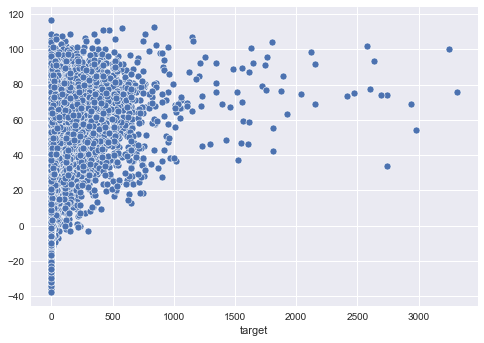

In [223]:
#df_plot = DataFrame([y_test, y_pred], )
ax = sns.scatterplot(x=y_test, y=y_pred)